In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats

In [2]:
age_gender = pd.read_csv("age_gender_bkts.csv")
countries = pd.read_csv("countries.csv")
session = pd.read_csv("sessions.csv")
train_user = pd.read_csv("train_users_2.csv")
test_user = pd.read_csv("test_users.csv")

# 아래 코드에서 시간 기준을 설정하여 
# 재방문율을 구하는게 가장 합리적일것같다

action의 어떤 속성이 실제 예약인지 파악할수가 없었다.  
어떻게 처리를 하던 100% or 97.n%가 나왔다.  
100%의 경우에는 action 행의 null값이 제거된 경우이고 97.n%의 경우에는 결측치 처리를 하지 않은 경우이다.  
코딩의 이슈라고 판단되어 GPT의 도움을 받았음에도 결과는 똑같았다.  
그나마 세션 이용 텀이 secs_elapse 전체의 평균(45일)보다 크거나 최빈값(3일)보다 큰 경우로 해보았을때  
100%, 97.n%가 나오지 않았다. 이 부분의 기준을 세워야 할듯. 

session의 userid 는 userid별로 언제 사용했든 연속적으로 기록했다고 함. 그래서 아무리 나누어 보고 해도 97.n%가 나온듯.  
action의 어떤 속성이 실제 예약인지 파악한다고 해도 secs_elapsed 컬럼이 어떤 단위인지. 뭘 기준으로 기록된건지 알수가 없다.  
show에 20만초... 약 2.5일간 한페이지만 보고있다고 봐야하는지 마지막 세션 이후 2.5일이 지난것인지 판단하기가 어렵다.  

--- 

action에 book 이 들어가는 속성이 실제 예약과 연관이 있을것이라 판단하고 분석 진행했다.  
facebook 연동, 로그인 이런건 제외하고 book, guest_booked_elsewhere, booking 속성만 추출하여  
이 속성이 등장한 이후에도 동일한 user id 인 행이 존재하는 id를 추출했다.  
session의 고유한 user id의 갯수와 위의 조건에 만족하는 user id의 갯수 비율은 0.14%로 매우 적은 수치였다.


In [30]:
# 필요한 컬럼 선택 및 전처리
user_data = train_user[['id', 'date_account_created', 'date_first_booking']]
user_data['date_account_created'] = pd.to_datetime(user_data['date_account_created'])
user_data['date_first_booking'] = pd.to_datetime(user_data['date_first_booking'])

# user_id별로 정렬
sessions_sorted = session.sort_values(by=['user_id', 'secs_elapsed'])

# 사용자별 활동 간격 계산
sessions_sorted['prev_secs_elapsed'] = sessions_sorted.groupby('user_id')['secs_elapsed'].shift(1)
sessions_sorted['time_diff'] = sessions_sorted['secs_elapsed'] - sessions_sorted['prev_secs_elapsed']

# 일정 시간 간격을 기준으로 텀 여부 확인 (예: 1시간 = 3600초)
time_gap_threshold = 3600 * 24 * 7
sessions_sorted['has_gap'] = sessions_sorted['time_diff'] > time_gap_threshold

# user_id별로 텀 여부 확인
user_gap_info = sessions_sorted.groupby('user_id')['has_gap'].any().reset_index()
user_gap_info.columns = ['user_id', 'has_time_gap']

# 결과 확인
print(user_gap_info.head())

# 텀 여부 통계 확인
gap_stats = user_gap_info['has_time_gap'].value_counts()
print(gap_stats)

/tmp/ipykernel_9694/503929656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['date_account_created'] = pd.to_datetime(user_data['date_account_created'])
/tmp/ipykernel_9694/503929656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['date_first_booking'] = pd.to_datetime(user_data['date_first_booking'])


      user_id  has_time_gap
0  00023iyk9l         False
1  0010k6l0om         False
2  001wyh0pz8         False
3  0028jgx1x1         False
4  002qnbzfs5          True
has_time_gap
False    114861
True      20622
Name: count, dtype: int64


In [4]:
session.head(100)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
95,d1mm9tcy42,show,NaN,NaN,Windows Desktop,38.0
96,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,917.0
97,d1mm9tcy42,show,view,p3,Windows Desktop,130462.0
98,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,443.0


In [3]:
# 필요한 컬럼 선택 및 전처리
user_data = train_user[['id', 'date_account_created', 'date_first_booking']]
user_data['date_account_created'] = pd.to_datetime(user_data['date_account_created'])
user_data['date_first_booking'] = pd.to_datetime(user_data['date_first_booking'])

# 2014년 1월 1일 이후에 계정을 생성한 사용자만 필터링
user_data_after_2014 = user_data[user_data['date_account_created'] >= '2014-01-01']

# 사용자 데이터와 세션 데이터를 병합
merged_data = session.merge(user_data_after_2014[['id', 'date_account_created', 'date_first_booking']], left_on='user_id', right_on='id', how='left')

# 세션 데이터에서 활동 날짜 계산
merged_data['session_date'] = merged_data['date_account_created'] + pd.to_timedelta(merged_data['secs_elapsed'], unit='s')

# 유지율 계산을 위한 기간 설정 (1일, 7일, 30일, 45일)
periods = [1, 7, 30, 45]

# 각 기간에 대해 유지율 계산
retention_rates = {}
for period in periods:
    period_end_date = merged_data['date_first_booking'] + pd.Timedelta(days=period)
    revisit_sessions_within_period = merged_data[merged_data['session_date'] <= period_end_date]
    revisit_user_ids = revisit_sessions_within_period['user_id'].unique()
    total_users_with_first_booking = user_data_after_2014['date_first_booking'].notnull().sum()
    revisit_user_count = len(revisit_user_ids)
    retention_rate = revisit_user_count / total_users_with_first_booking
    retention_rates[period] = retention_rate

# 결과 출력
for period, rate in retention_rates.items():
    print(f"Retention rate after {period} days: {rate:.2%}")


/tmp/ipykernel_3857/4189631411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['date_account_created'] = pd.to_datetime(user_data['date_account_created'])
/tmp/ipykernel_3857/4189631411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['date_first_booking'] = pd.to_datetime(user_data['date_first_booking'])


Retention rate after 1 days: 97.02%
Retention rate after 7 days: 97.12%
Retention rate after 30 days: 97.16%
Retention rate after 45 days: 97.16%


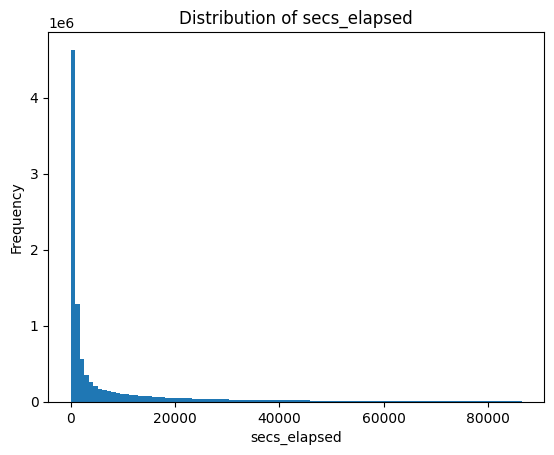

                           action  average_secs_elapsed
0                              10          32881.136219
1                              11          44026.497561
2                              12          30721.155844
3                              15          37454.785311
4                        about_us          21396.818681
..                            ...                   ...
353  weibo_signup_referral_finish          15113.386364
354                      why_host          23515.537415
355                        widget           2853.945946
356                     wishlists          35116.000000
357             zendesk_login_jwt          14361.590909

[358 rows x 2 columns]


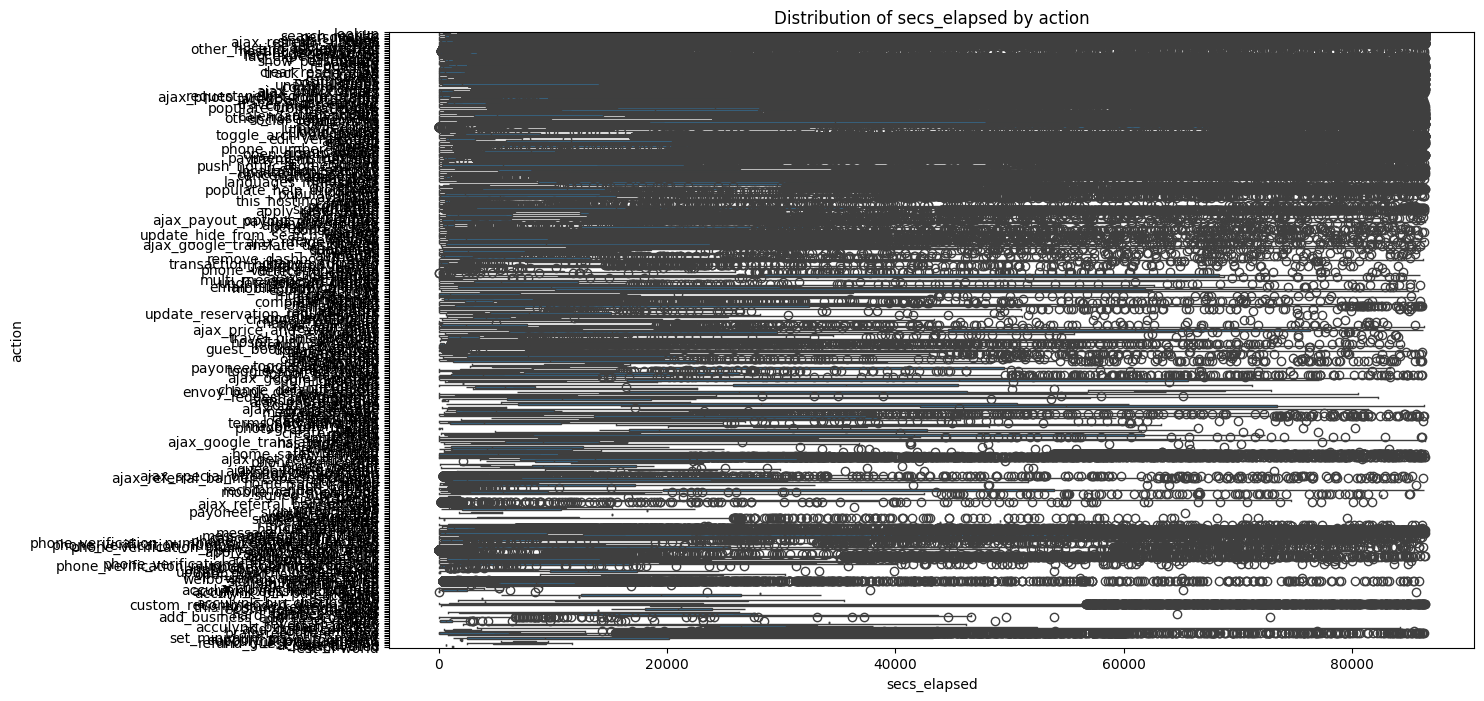

In [7]:
# secs_elapsed 값의 분포 확인
plt.hist(session['secs_elapsed'].dropna(), bins=100)
plt.title('Distribution of secs_elapsed')
plt.xlabel('secs_elapsed')
plt.ylabel('Frequency')
plt.show()

# 비정상적인 값 제거
max_secs_elapsed = 86400  # 1일

# 비정상적인 값을 NaN으로 설정
session['secs_elapsed'] = session['secs_elapsed'].apply(lambda x: x if x <= max_secs_elapsed else None)

# 비정상적인 값을 포함한 행 제거
sessions = session.dropna(subset=['secs_elapsed'])

# action별 평균 소요 시간 계산 (비정상적인 값 제거 후)
action_time = sessions.groupby('action')['secs_elapsed'].mean().reset_index()
action_time.columns = ['action', 'average_secs_elapsed']

# 결과 출력
print(action_time)

# action별 secs_elapsed 값의 분포 시각화 (상자 그림)
plt.figure(figsize=(14, 8))
sns.boxplot(data=sessions, x='secs_elapsed', y='action')
plt.title('Distribution of secs_elapsed by action')
plt.xlabel('secs_elapsed')
plt.ylabel('action')
plt.show()

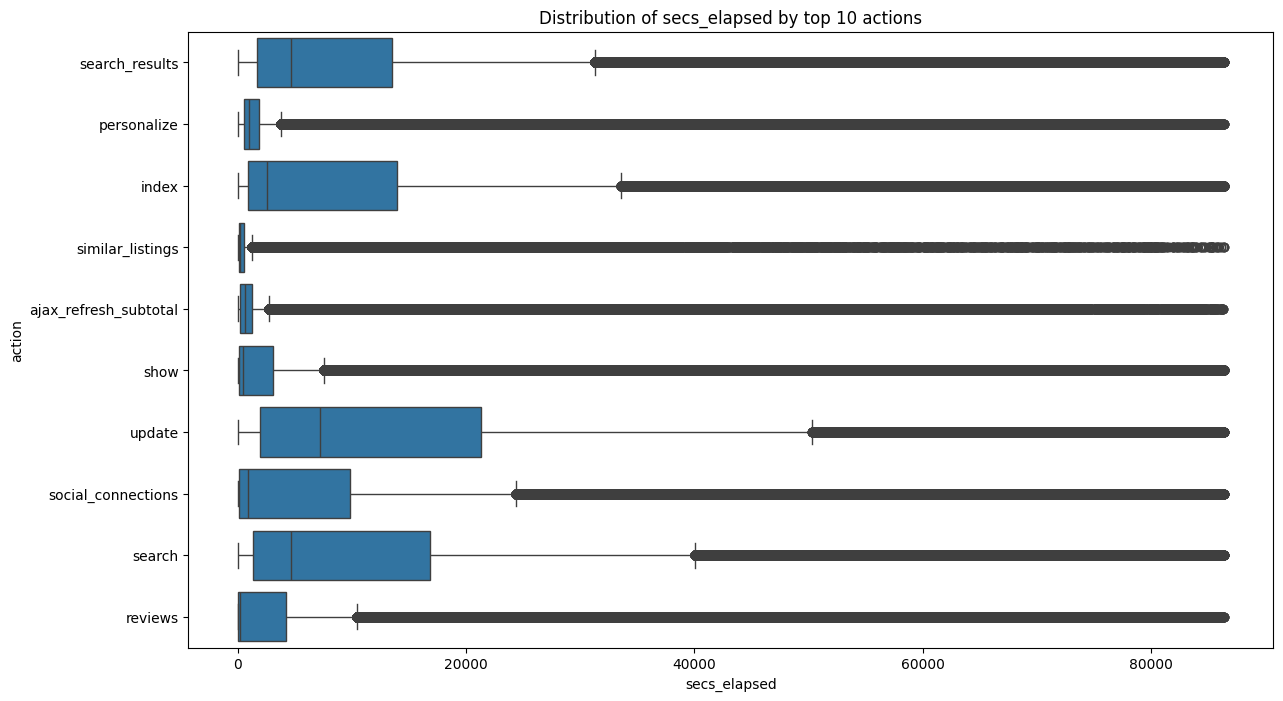

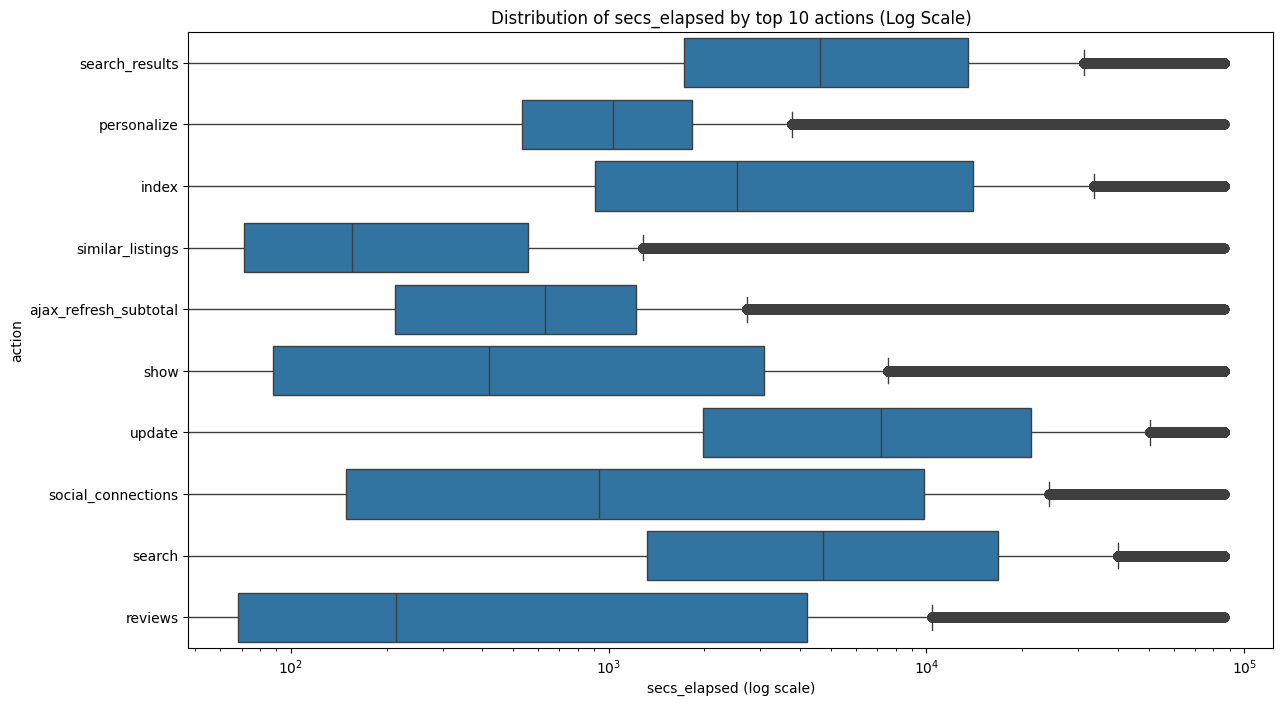

In [9]:
# 비정상적인 값 제거
max_secs_elapsed = 86400  # 1일
session['secs_elapsed'] = session['secs_elapsed'].apply(lambda x: x if x <= max_secs_elapsed else None)
sessions = session.dropna(subset=['secs_elapsed'])

# 상위 10개의 action 선택
top_actions = sessions['action'].value_counts().head(10).index
top_sessions = sessions[sessions['action'].isin(top_actions)]

# 상위 10개의 action별 secs_elapsed 값의 분포 시각화 (상자 그림)
plt.figure(figsize=(14, 8))
sns.boxplot(data=top_sessions, x='secs_elapsed', y='action')
plt.title('Distribution of secs_elapsed by top 10 actions')
plt.xlabel('secs_elapsed')
plt.ylabel('action')
plt.show()

# 상위 10개의 action별 secs_elapsed 값의 분포 시각화 (로그 스케일)
plt.figure(figsize=(14, 8))
sns.boxplot(data=top_sessions, x='secs_elapsed', y='action')
plt.xscale('log')
plt.title('Distribution of secs_elapsed by top 10 actions (Log Scale)')
plt.xlabel('secs_elapsed (log scale)')
plt.ylabel('action')
plt.show()


action
show              2768278
index              843699
search_results     725226
personalize        706824
search             536057
                   ...   
deauthorize             1
events                  1
reactivate              1
desks                   1
nyan                    1
Name: count, Length: 359, dtype: int64
Users who performed booking actions: 7958


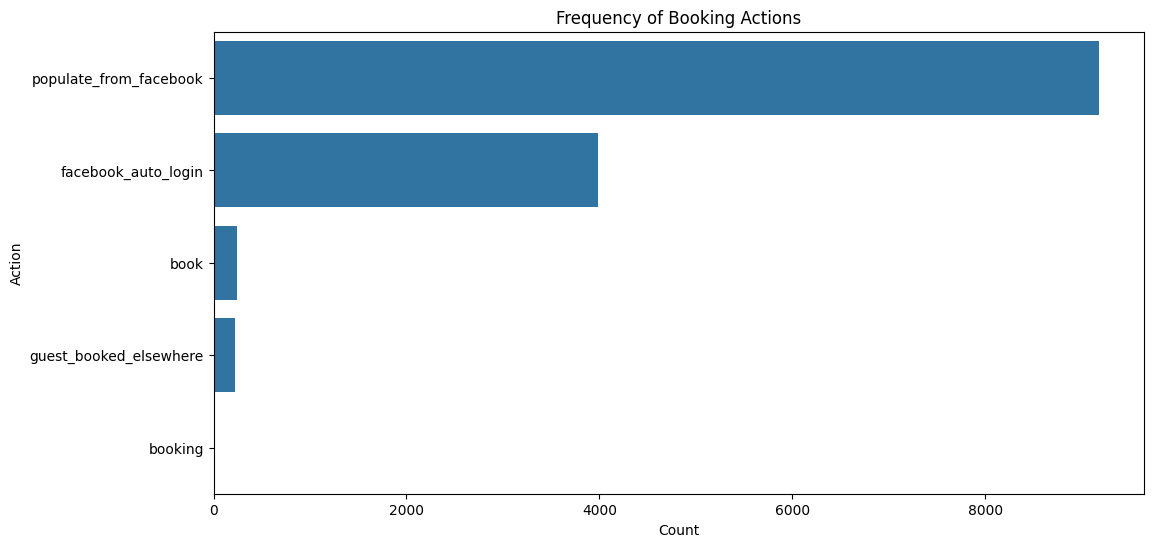

In [11]:
action_counts = session['action'].value_counts()
print(action_counts)

# 예시로 "book"과 "reserve"가 포함된 action을 예약 관련 action으로 간주
booking_actions = [action for action in action_counts.index if 'book' in action or 'reserve' in action]

# 예약과 관련된 action 값을 필터링하여 사용자 ID 추출
booking_sessions = session[session['action'].isin(booking_actions)]
booking_user_ids = booking_sessions['user_id'].unique()

print(f"Users who performed booking actions: {len(booking_user_ids)}")

# 예약과 관련된 action 값의 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=booking_sessions, y='action', order=booking_sessions['action'].value_counts().index)
plt.title('Frequency of Booking Actions')
plt.xlabel('Count')
plt.ylabel('Action')
plt.show()

In [13]:
# 'book' 또는 'guest_booked_elsewhere' action을 가진 user_id 필터링
booking_actions = ['book', 'guest_booked_elsewhere']
filtered_sessions = session[session['action'].isin(booking_actions)]

# 필터링된 user_id 추출
booking_user_ids = filtered_sessions['user_id'].unique()

# 전체 세션 데이터에서 해당 user_id의 다음 행을 확인
# user_id가 동일한 경우를 찾기 위해 정렬
sessions = sessions.sort_values(by=['user_id', 'secs_elapsed'])

# 동일한 user_id가 다음 행에 존재하는지 확인
sessions['next_user_id'] = sessions['user_id'].shift(-1)
revisit_user_ids = sessions[(sessions['user_id'].isin(booking_user_ids)) & (sessions['user_id'] == sessions['next_user_id'])]['user_id'].unique()

print(f"User IDs with consecutive bookings: {revisit_user_ids}")
print(f"Total: {len(revisit_user_ids)}")

# 전체 고유 user_id 수 계산
total_unique_user_ids = sessions['user_id'].nunique()

# 재방문 고유 user_id 수 계산
revisit_user_count = len(revisit_user_ids)

# 비율 계산
revisit_rate = revisit_user_count / total_unique_user_ids

# 결과 출력
print(f"Total unique user IDs: {total_unique_user_ids}")
print(f"User IDs with consecutive bookings: {revisit_user_count}")
print(f"Revisit Rate: {revisit_rate:.2%}")

User IDs with consecutive bookings: ['02z0mwv33k' '04l00vzqt6' '0fgeemmp08' '10n65lxqr8' '1ax0w5thkg'
 '1bcz2qgkrx' '26kxkbsqy9' '2b56aqtatj' '2goixwt8nn' '2l55pg7d8k'
 '2mf26mhm2r' '2okqlo3hoi' '2pa5y1yfyn' '2ral2k4rc9' '2zp49y74ea'
 '337zm32xg2' '37jnj6zt5j' '3kaafu7oip' '3lkffwf15w' '3lwd7i5eyl'
 '3qr99rvx3w' '3rw03odtpp' '3v9l3i09mw' '46ob64tjto' '48im6sgb14'
 '4bwxbstkxv' '4fhugxkcik' '4j3f2irkbh' '4x1drxfi6i' '5jj15wx08j'
 '5lufs1wqyp' '62axa5tckx' '67n8wmn67w' '6negpr0jjx' '6ottewawfg'
 '6sx45i5iyr' '6trz05m8t7' '6zx5nm403s' '75s9of3ma1' '7eqo1wcro8'
 '7jmglvchee' '815dogvins' '85kmcv2qoq' '86ujv126l7' '880dx8auo9'
 '89b3z4mjs1' '8c0kej2ij5' '8yxlq79zqv' '9utfujk1ol' '9yp8tjpexr'
 'a3a8ngb1cf' 'aeika8iyhb' 'amjlzsm4q0' 'anw9us995j' 'bzsoyb13fh'
 'c2c73gkv9f' 'c58mt0ubnv' 'c8tb4opno4' 'ceqrtrerfo' 'd0les2vm3e'
 'd1n9i83u99' 'd548nfav5q' 'dojtk7p5i4' 'dqkqqsyqn2' 'du5ty591k0'
 'e5b0g2fbx2' 'eph8zxs0do' 'euglznkfsu' 'exiyxrt81v' 'eyy14cpfo4'
 'ezhv9szqvu' 'f7vsjjav14' 'fdhwdtr81t' 